In [2]:
import numpy as np
import pandas as pd
import os 
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import SGDClassifier,LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
import spacy
import string
import re
from nltk.corpus import sentiwordnet as swn
import time
import itertools
import operator
from gensim import corpora,models
%matplotlib inline

In [3]:
DIR_PATH = '../input'
data = pd.read_csv('{}/{}'.format(DIR_PATH,'train.csv'))
test_data = pd.read_csv('{}/{}'.format(DIR_PATH,'test.csv'))
sample = data.iloc[:100]

**DATA CLEANING, STEMMING, PUNCTUATIONS/STOP-WORDS REMOVAL , TF-IDF MATRIX CREATION (FEATURE-MATRIX FOR EACH CORPUS (SET OF DOCUMENTS))**

In [23]:
STOPWORDS = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')

def tokenize_text(row,col) : 
    ar = nltk.word_tokenize(row[col])
    return [i.lower() for i in ar]


def remove_stopwords(row,col) : 
    token_set = set(row[col])
    sw_set = set(STOPWORDS)
    return list(token_set.difference(sw_set))

def text_purity(row,col_original,col_new) : 
    original_text = len(row[col_original])
    new_text = len(row[col_new])
    return int(new_text)/int(original_text)
    
def stemming(row,col) : 
    stemmer = nltk.stem.WordNetLemmatizer()
    #stemmer = nltk.stem.snowball.PorterStemmer()
    return [stemmer.lemmatize(w) for w in row[col]]
    
def stem_word_count(row,col) : 
    return len(row[col].values.tolist())

def tag_tokens(row,col,tokens=False) : 
    doc = nlp(row[col])
    return [(t.text,t.tag_) for t in doc]

def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    return filtered_tokens
    
def remove_punct(row,col) :
    return list(remove_characters_after_tokenization(row[col]))
    
def extract_keyword_weights(row,col,NUM_TOPICS) : 
    sents=row[col]
    print(sents)
    tokens = list(map(lambda x:nltk.word_tokenize(x),sents))
    lsi = train_lsi_model_gensim(tokens,total_topics=NUM_TOPICS)
    parse_weighted_lsi_model(lsi)
    return parse_weighted_lsi_model

def feature_matrix_fit(data,vect_type,data_col) : 
    
    input_data = data[data_col].values
    if vect_type == 'count' : vectorizer = CountVectorizer(min_df=0.0,max_df=1.0,analyzer='word',ngram_range=(1,1))
    elif vect_type == 'tfidf' :   vectorizer = TfidfVectorizer(min_df=0.0,max_df=1.0,analyzer='word',ngram_range=(1,1))   
    features = vectorizer.fit_transform(input_data)
    return vectorizer,features
    
def feature_engineering(data) : 
    
    ## input should be a df
    data['tokens'] = data.apply(tokenize_text,args=('text',),axis=1)
    data['tokens'] = data.apply(remove_punct,args=('tokens',),axis=1)
    data['token_string'] = data.apply(lambda x:' '.join(x['tokens']),axis=1)
    data['no_sw'] = data.apply(remove_stopwords,args=('tokens',),axis=1)
    data['purity'] = data.apply(text_purity,args=('tokens','no_sw',),axis=1)
    data['no_sw_string'] = data.apply(lambda x:' '.join(x['no_sw']),axis=1)
    data['stemmed'] = data.apply(stemming,args=('no_sw',),axis=1)
    data['wc_stemmed'] = data.apply(lambda x:len(x['stemmed']),axis=1)
    data['stemmed_string'] = data.apply(lambda x:' '.join(x['stemmed']),axis=1)
    
    
    ## SCALING
    scaler = MinMaxScaler(feature_range=(0,1))
    wc_stemmed_feature = scaler.fit_transform(data['wc_stemmed'].values.reshape(-1,1))
    data['wc_stemmed_scaled'] = wc_stemmed_feature
    
    encoder = LabelEncoder()
    e=encoder.fit_transform(data['author'].values)
    data['author_en'] = e              
    return data
    
train_data = feature_engineering(data)

## REMOVING OUTLIERS
train_data = train_data[train_data['wc_stemmed']<40]
vect,train_features = feature_matrix_fit(train_data,vect_type='count',data_col='stemmed_string')

## MANUALLY ADDING FEATURES

print(train_features.shape)
print(train_data['wc_stemmed_scaled'].shape)

train_features = np.append(train_features.toarray(),train_data['wc_stemmed_scaled'].values.reshape(-1,1),axis=1)
train_features = np.append(train_features,train_data['purity'].values.reshape(-1,1),axis=1)

train_labels = train_data['author']
xtrain,xtest,ytrain,ytest = train_test_split(train_features,train_labels)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:585: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(19358, 21429)
(19358,)


**TRAIN-SET : [num_samples] * [distinct_words] wheareas each value in feature_matrix is tf_idf number [0-1] **

In [ ]:
ax1=train_data[['author','wc_stemmed']].boxplot(by='author',figsize=(15,10))

eap = train_data[train_data['author']=='EAP'][['purity','wc_stemmed_scaled']]
hpl = train_data[train_data['author']=='HPL'][['purity','wc_stemmed_scaled']]
mws = train_data[train_data['author']=='MWS'][['purity','wc_stemmed_scaled']]
ax2=eap.plot.scatter(x='purity',y='wc_stemmed_scaled',color='Red',figsize=(15,10),label='EAP')
hpl.plot.scatter(x='purity',y='wc_stemmed_scaled',color='Green',figsize=(15,10),label='HPL',ax=ax2)
mws.plot.scatter(x='purity',y='wc_stemmed_scaled',color='Blue',figsize=(15,10),label='MWS',ax=ax2)
""

''

In [31]:
train_labels.shape

(19358,)

In [32]:
xtrain.shape

(14518, 21431)

**FUNCTIONS DEFININGS LSI MODEL (INFORMATION REDUCTION) FOR TOPIC-MODELLING**

In [14]:
def train_lsi_model_gensim(corpus, total_topics=2):
    dictionary = corpora.Dictionary(corpus)
    mapped_corpus = [dictionary.doc2bow(text) for text in corpus]
    tfidf = models.TfidfModel(mapped_corpus)
    corpus_tfidf = tfidf[mapped_corpus]
    lsi = models.LsiModel(corpus_tfidf,id2word=dictionary,num_topics=total_topics)
    return lsi

def parse_weighted_lsi_model(lsi_model) :
    TOPIC_ARRAY = []
    def parse_lsi_eq(eq) : 
        REGEX=r'([\-0-9\.]+)\*\"([a-z]+)\"'
        return re.findall(REGEX,eq)      
    output = lsi_model.print_topics()
    for t in output : 
        topic_num=t[0]
        topic_eq=t[1]
        TOPIC_ARRAY.append(parse_lsi_eq(topic_eq))
    return TOPIC_ARRAY

def extract_keyword_weights(row,col,NUM_TOPICS) : 
    sent=row[col]
    tokens = nltk.word_tokenize(sent)
    print(tokens)
    lsi = train_lsi_model_gensim([tokens],total_topics=NUM_TOPICS)
    return parse_weighted_lsi_model(lsi)


#sample_data= data.iloc[2:4]
#sample_data['keywords'] = sample_data.apply(extract_keyword_weights,args=('token_string',NUM_TOPICS),axis=1)
#sample_data[['token_string','keywords']].values


**[NOT COMPLETED] : CREATING A METRIC THAT CALCULATES COSINE DISTANCE FROM FELLOW PARAGRAPHS(PARA WITH SAME AUTHOR) AND OTHER PARAGRAPHS(PARAS WITH THE OTHER AUTHOR)**

In [15]:
def cosine_distance(u,v) : 
    dist = 1.0 - (np.dot(u,v)/(np.sqrt(sum(np.square(u))) * np.sqrt(sum(np.square(v)))))
    return dist
    
def test_similarity_scores(train_feature_matrix,test_vector) : 
    y=test_vector
    return list(map(lambda x:cosine_distance(x,y),train_feature_matrix))

def label_closeness(N,xtrain,ytrain,test_vector) :
    ## returns average closness to each class label
    
    scores=test_similarity_scores(xtrain[:N],test_vector)
    df = pd.DataFrame([[sc,aut] for sc,aut in zip(scores,ytrain[:N])],columns=['dist_score','author'])
    v = df.groupby('author').mean().values
    return v

def feature_matrix_fit(data,vect_type,data_col) : 
    
    input_data = data[data_col].values
    if vect_type == 'count' : 
        vectorizer = CountVectorizer(min_df=0.0,max_df=1.0,analyzer='word',ngram_range=(1,1))
    elif vect_type == 'tfidf' : 
        vectorizer = TfidfVectorizer(min_df=0.0,max_df=1.0,analyzer='word',ngram_range=(1,1))
        
    features = vectorizer.fit_transform(input_data)
    return vectorizer,features




** EXPLORATION : COLLOCATIONS FINDING FROM NO_SW TOKENS**

In [17]:
from nltk.collocations import BigramCollocationFinder,TrigramCollocationFinder
from nltk.collocations import BigramAssocMeasures,TrigramAssocMeasures
import string


tokens=nltk.word_tokenize(' '.join(train_data['no_sw_string'].values))
finder = TrigramCollocationFinder.from_words(tokens)
measures = TrigramAssocMeasures()
finder.nbest(measures.pmi,10)


[('accrue', 'raiders', 'hinting'),
 ('al', 'contento', 'pensiero'),
 ('albano', 'waggeries', 'frows'),
 ('amenity', 'rubens', 'cimabué'),
 ('antlered', 'proteges', 'worthier'),
 ('apocryphal', 'maine', 'courier'),
 ('auburn', 'holmes', 'lowell'),
 ('auction', 'prentice', 'cobbett'),
 ('awesomely', 'dissociate', 'ichthyic'),
 ('barac', 'sauterne', 'chambertin')]

 **LSI MODEL) WITH SVD AND TF-IDF BASED MATRIX**

In [33]:
def get_chunks(sentences, grammar = r'NP: {<DT>? <JJ>* <NN.*>+}'):
    ## sentences is list of sentences
    SW_LIST=stopwords.words('english')
    all_chunks = []
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    
    def key_func(TUPLE) : 
        chunk = TUPLE[2]
        if chunk!='O': 
            return chunk 
        
    for sentence in sentences:
        tagged_sents = nltk.pos_tag_sents([nltk.word_tokenize(sentence)])
        chunks = [chunker.parse(tagged_sent)for tagged_sent in tagged_sents]
        wtc_sents = [nltk.chunk.tree2conlltags(chunk) for chunk in chunks]    
        flattened_chunks = list( itertools.chain.from_iterable(wtc_sent for wtc_sent in wtc_sents) )    
        valid_chunks_tagged = [(status, [wtc for wtc in chunk]) for status, chunk  in itertools.groupby(flattened_chunks,key_func)]
        valid_chunks = [' '.join(word.lower()  for word, tag, chunk in wtc_group if word.lower() not in SW_LIST) for status, wtc_group in valid_chunks_tagged if status]
        all_chunks.append(valid_chunks)
    
    return all_chunks

def get_tfidf_weighted_keyphrases(sentences,grammar=r'NP: {<DT>? <JJ>* <NN.*>+}',top_n=10):

    valid_chunks = get_chunks(sentences, grammar=grammar)
    dictionary = corpora.Dictionary(valid_chunks)
   # print('dict : {}'.format(dictionary))
    corpus = [dictionary.doc2bow(chunk) for chunk in valid_chunks]
    #print('corpus : {}'.format(corpus))
    tfidf = models.TfidfModel(corpus)
    #print('tfidf : {}'.format(tfidf))
    corpus_tfidf = tfidf[corpus]
    #print('corpus_tfidf : {}'.format(corpus_tfidf))
    weighted_phrases = {dictionary.get(id): round(value,3) for doc in corpus_tfidf for id, value in doc}
    weighted_phrases = sorted(weighted_phrases.items(),key=operator.itemgetter(1), reverse=True)
    #print('weighted : {}'.format(weighted_phrases))
    return weighted_phrases[:top_n]


def train_lsi_model_gensim(corpus, total_topics=2):
    norm_tokenized_corpus = corpus
    dictionary = corpora.Dictionary(norm_tokenized_corpus)
    mapped_corpus = [dictionary.doc2bow(text) for text in norm_tokenized_corpus]
    tfidf = models.TfidfModel(mapped_corpus)
    corpus_tfidf = tfidf[mapped_corpus]
    lsi = models.LsiModel(corpus_tfidf,id2word=dictionary,num_topics=total_topics)
    return lsi

def parse_weighted_lsi_model(lsi_model) :
    TOPIC_ARRAY = []
    def parse_lsi_eq(eq) : 
        REGEX=r'([\-0-9\.]+)\*\"([a-z]+)\"'
        return re.findall(REGEX,eq)      
    output = lsi.print_topics()
    for t in output : 
        topic_num=t[0]
        topic_eq=t[1]
        TOPIC_ARRAY.append(parse_lsi_eq(topic_eq))
    return TOPIC_ARRAY

In [19]:
toy_text = """
Elephants are large mammals of the family Elephantidae
and the order Proboscidea. Two species are traditionally recognised,
the African elephant and the Asian elephant. Elephants are scattered
throughout sub-Saharan Africa, South Asia, and Southeast Asia. Male
African elephants are the largest extant terrestrial animals. All
elephants have a long trunk used for many purposes,
particularly breathing, lifting water and grasping objects. Their
incisors grow into tusks, which can serve as weapons and as tools
for moving objects and digging. Elephants' large ear flaps help
to control their body temperature. Their pillar-like legs can
carry their great weight. African elephants have larger ears
and concave backs while Asian elephants have smaller ears
and convex or level backs.
"""
NUM_TOPICS=2

def extract_keyword_weights(row,col,NUM_TOPICS) : 
    sents=row[col].values
    tokens = list(map(lambda x:nltk.word_tokenize(x),sents))
    lsi = train_lsi_model_gensim(tokens,total_topics=NUM_TOPICS)
    
    return parse_weighted_lsi_model(lsi)




In [35]:
get_tfidf_weighted_keyphrases(train_data['stemmed_string'].values)

In [ ]:
def parse_lsi_eq(eq) : 
        REGEX=r'([\-0-9\.]+)\*\"([a-z]+)\"'
        return re.findall(REGEX,eq)
x=parse_lsi_eq(output[0][1])
x

**[MODEL VALUATION] : MULTINOMIAL NB FOR CLASSIFICATION : PROVIDED PARAGRAPH WHO IS THE AUTHOR ? : 0.83 ACCURACY SCORE** 

/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


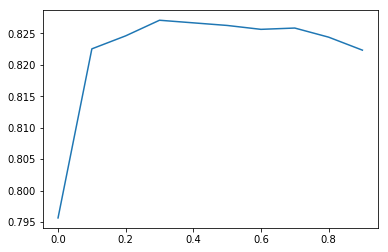

In [26]:
ALPHA=np.arange(0,1,0.1)
ALPHA_SCORE=[]
for alpha in ALPHA : 
    MNB_model = MultinomialNB(alpha=alpha,fit_prior=False)
    MNB_model.fit(xtrain,ytrain)
    score2=MNB_model.score(xtest,ytest)
    ALPHA_SCORE.append(score2)
    #print('Multinomial NB = {}, alpha={}'.format(score2,alpha))
    
ax=plt.plot(ALPHA,ALPHA_SCORE)

In [27]:
#svm = SGDClassifier(loss='hinge',n_iter=100)
#svm.fit(xtrain,ytrain)
#score3=svm.score(xtest,ytest)
#print('SVM = {}'.format(score3))
logr=LogisticRegression(
        fit_intercept=True,
        random_state=0,
        max_iter=300,
        multi_class='ovr',
        n_jobs=1
)

logr.fit(xtrain,ytrain)
logr.score(xtest,ytest)

0.8064049586776859

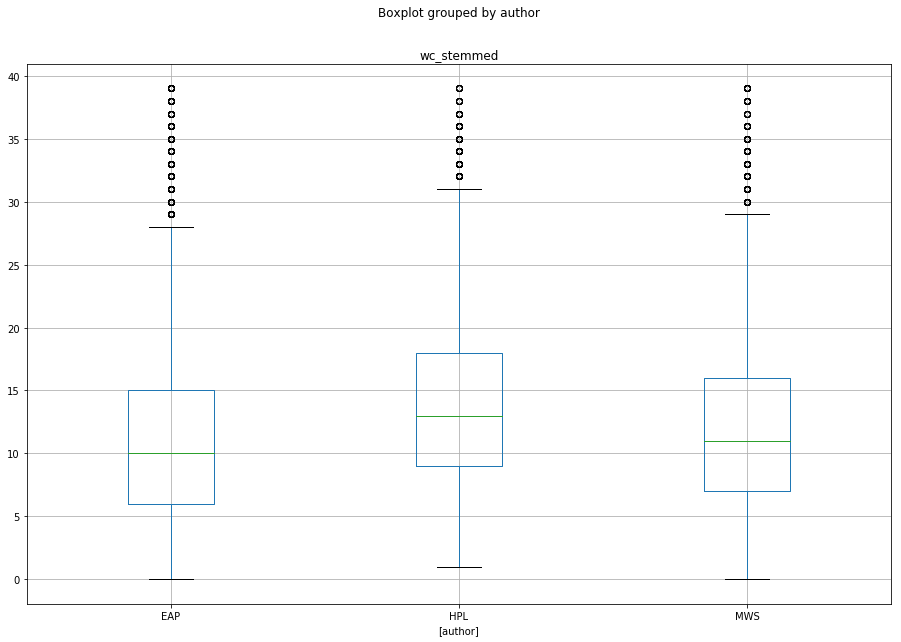

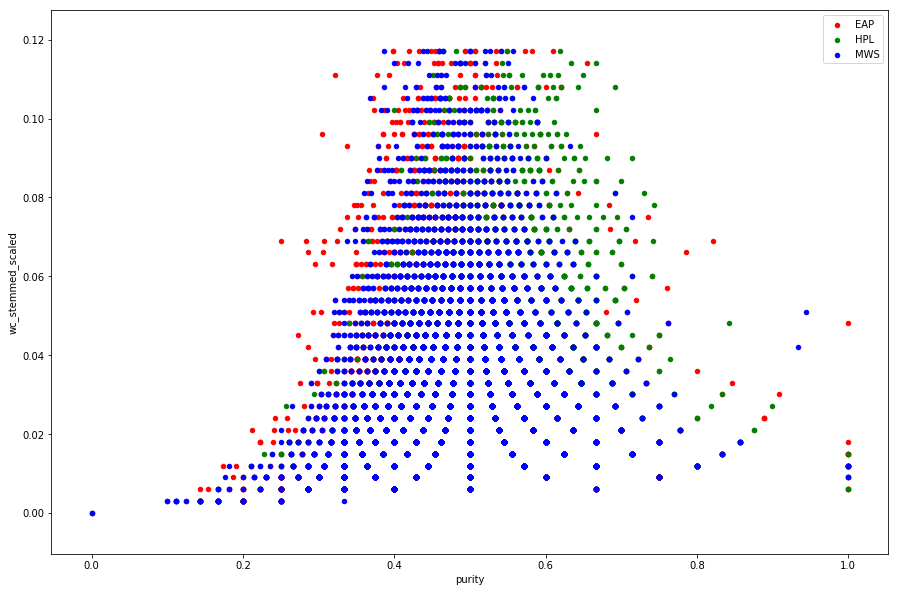